# Python Warm-up

This is a warm-up notebook to demonstrate some python APIs we will use frequently during our workshop. We'll play with class/functions, `numpy`, `matplotlib`, and `pandas`.

In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Python function and class
Defining a class or function in Python is as simple as this:

In [3]:
def foo(x):
    """
    Args: x ... numerical variable
    Return: x*x
    """
    return x**2

class bar:
    def __init__(self):
        self._data = [foo(v) for v in np.random.random(10)]
    # This implements len built-in function return
    def __len__(self):
        return len(self._data)
    # This implements random-access operator (i.e. [idx]) return
    def __getitem__(self,idx):
        return self._data[idx]
    # This implements string representation
    def __str__(self):
        return 'I am an instance of bar!'
    # This is a secret function
    def _secret_(self):
        print('HOW DID YOU KNOW?!')

In [4]:
help(foo)

Help on function foo in module __main__:

foo(x)
    Args: x ... numerical variable
    Return: x*x



In [5]:
kazu = bar()
print('Length of kazu',len(kazu))
print('5th element of kazu',kazu[5])
print(kazu)

Length of kazu 10
5th element of kazu 0.012937489401348588
I am an instance of bar!


Because python is so sketchy (i.e. awesome), you can attach an attribute anytime (dynamically).

In [6]:
kazu.name = "kazu"

Yes, this means, in a running program, attributes can be dynamically declared. We can write a program in which we let a user to define a new attribute name, type, and value dynamically. But you can also always check what are the attributes that belong to any object (either instance or class itself):

In [7]:
print('Attribute variable list:',kazu.__dict__.keys())

Attribute variable list: dict_keys(['_data', 'name'])


More generic way of checking whether an instance has a named attribute, whether a variable or a function pointer, is to use `hasattr` and `getattr` built-in methods. 

In [8]:
print('Does a class bar has an attribute "name"?','Yes' if hasattr(bar,'name') else 'No')
print('Does the object kazu has an attribute "name"?','Yes' if hasattr(kazu,'name') else 'No')
print('kazu.name value is',getattr(kazu,'name'))

Does a class bar has an attribute "name"? No
Does the object kazu has an attribute "name"? Yes
kazu.name value is kazu


## Image Visualization & Numpy Array Slicing
We will use a `Homer.png` image file.

In [9]:
data=plt.imread('Homer.png')
print('Data shape:',data.shape)
print('Data type:',type(data))

Data shape: (500, 300, 4)
Data type: <class 'numpy.ndarray'>


So this image has 4 [CMYK channels](https://en.wikipedia.org/wiki/Channel_(digital_image)#CMYK). Let's visualize the image using `matplotlib.pyplot.imshow`

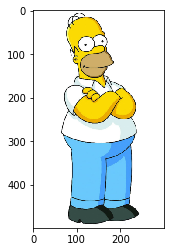

In [10]:
plt.imshow(data)
plt.show()

Next, make a canvas with (1,N) sub-plots, where we will draw a gray-scale image for each image channel by slicing one by one.

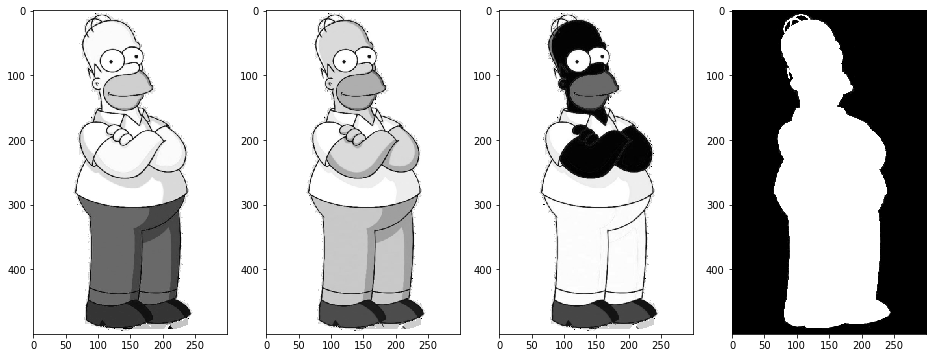

In [11]:
fig,axes=plt.subplots(1,data.shape[2],figsize=(16,8),facecolor='w')
for ch in range(data.shape[2]):
    axes[ch].imshow(data[:,:,ch],cmap='gray')
plt.show()

If you miss `ROOT` and in particular a _typical HEP color scale_ (i.e. dark blue, cyan, green, yellow, dark red respecitvely for increasing intensity), probably the easiest is to use `cmap='jet'`.

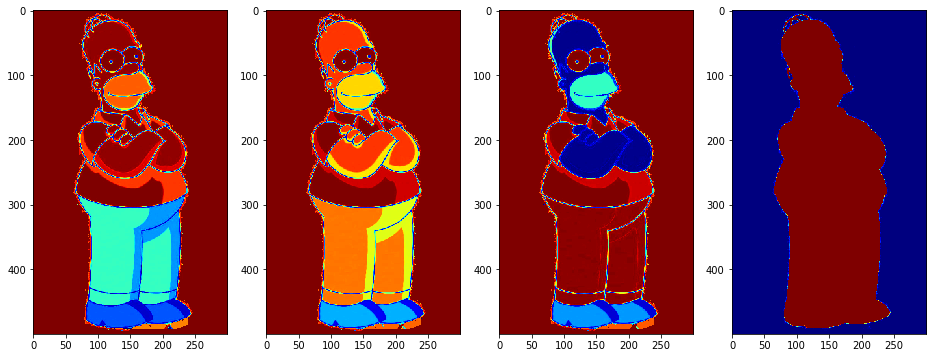

In [12]:
fig,axes=plt.subplots(1,data.shape[2],figsize=(16,8),facecolor='w')
for ch in range(data.shape[2]):
    axes[ch].imshow(data[:,:,ch],cmap='jet')
plt.show()

But what are the pixel values (pretend you don't know the answer please)? Let's slice then reshape into 1D array, and histogram pixel values per channel.

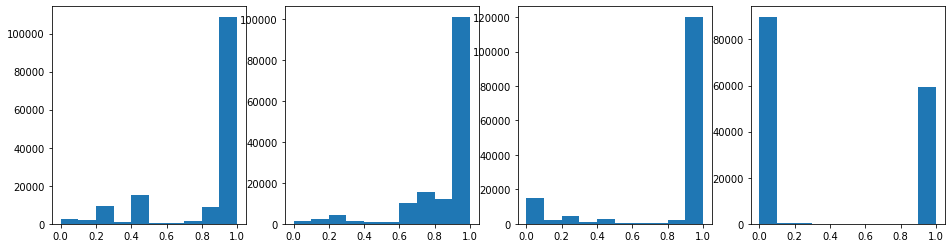

In [13]:
# list comprehension to make an array of 1D array data
data1d = [data[:,:,ch].reshape(-1) for ch in range(data.shape[2])]
# histogram values
fig,axes=plt.subplots(1,len(data1d),figsize=(16,4),facecolor='w')
for index,ch_data in enumerate(data1d):
    axes[index].hist(ch_data)
plt.show()

The last channel (right-most plot) is almost entirely 1.0 and 0.0. That channel shows the blackness, so it's basically all background pixels vs. foreground (Hormer's) pixels. But it seems there are some pixels in between those values? Zoom in:

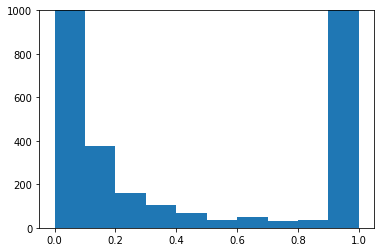

In [14]:
plt.hist(data1d[-1])
plt.ylim(0,1000)
plt.show()

Indeed there're some. Where are they? We would guess those must be the "boundary" pixels where the background transition into the foreground pixel values. Let's fine _where_ they are. 

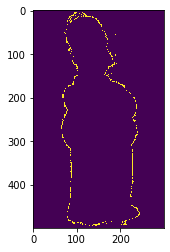

In [15]:
where = ((data[:,:,-1] > 0.) & (data[:,:,-1] < 1.)).astype(np.int32)
plt.imshow(where)

Woohoo! As expected we got the "edge" pixels. In the above, the variable `where` is a dense numpy array.

In [16]:
print(where.shape)

(500, 300)


... which holds 150,000 of 32-bit (4-byte) integers = 600kByte data! Yes that's small compared to RAM on your laptop or a smartphone. But it's a waste nonetheless. Let's sparcify them by just knowing the coordinates of non-zero points.

In [17]:
where_sparse = np.where(where>0)
print('2D coordinates:',np.shape(where_sparse))

2D coordinates: (2, 2365)


Now it's only 2365 pixels. Let's plot the locations!

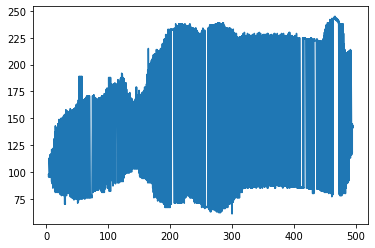

In [18]:
plt.plot(where_sparse[0],where_sparse[1])
plt.show()

Huh? Why is this image filled everywhere (and some bands of white?)?? We forgot that, by default, `matplotlib.pyplot.plot` draws lines between points. Ugh. Try again!

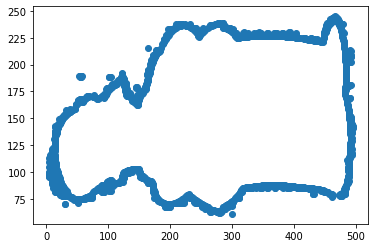

In [19]:
plt.plot(where_sparse[0],where_sparse[1],marker="o",markersize=6,linestyle='')
plt.show()

## Pandas
Pandas is an awesome data analysis and slicing tool, widely used in data analysis. `pandas.DataFrame` can represent table-like data and fully `numpy` compatible (i.e. columns are `numpy` arrays). 

### Creating `pandas.DataFrame`
You can create `pandas.DataFrame` from existing arrays, or create an empty one and append data.

In [20]:
df0 = pd.DataFrame([[0,1],[1,2]], columns=['Kazu','Patrick'])
print('Printing DataFrame')
print(df0)

Printing DataFrame
   Kazu  Patrick
0     0        1
1     1        2


The left column shows the index number. Each column is stored as `pandas.Series` object and we can access by the column name. The numpy array data is stored inside, and can be accessed by an attribute name `value`.

In [21]:
print('Access numpy column object',type(df0.Kazu.values))

Access numpy column object <class 'numpy.ndarray'>


DataFrames can be appended to another DataFrame:

In [22]:
df0.append(df0)

,Kazu,Patrick
0,0,1
1,1,2
0,0,1
1,1,2


In this case, however, we see that the index numbers are repeating. This is because the appended `DataFrame` object had the same index numbers. To avoid this and keep the index unique values (which can be useful), you can set `ignore_index` argument value to `False`:

In [23]:
df0.append(df0,ignore_index=True)

,Kazu,Patrick
0,0,1
1,1,2
2,0,1
3,1,2


The objects to append do not need to be a `DataFrame` object. Here is an example to append using a dictionary.

In [24]:
df0.append({'Kazu':2,'Patrick':3},ignore_index=True)

,Kazu,Patrick
0,0,1
1,1,2
2,2,3


When you have multiple `DataFrame` objects to be concatenated, `pandas.concat` is more efficient than looping over each `DataFrame` and append one by one:

In [25]:
pd.concat([df0,df0,df0])

,Kazu,Patrick
0,0,1
1,1,2
0,0,1
1,1,2
0,0,1
1,1,2


### Query & Groupby
Slicing `pandas.DataFrame` by a condition is very easy and more flexible options are intuitively available compred to `numpy` bare arrays.

In [26]:
particles = ['e','mu','proton','kaon','pi']

# Generate 1000 entries data, define 100 events (10 entries each).
# Each entry holds 10 "particle type" and "energy" information
data_particle = np.array([particles[int(np.random.random_sample()*len(particles))] for _ in range(1000)])
data_energy   = np.random.random(1000) * 1000.
data_event    = np.hstack([[i]*10 for i in range(100)])
index         = np.arange(0,1000)

# Create a dataframe
df = pd.DataFrame( {'event'    : pd.Series(data_event,index=index),
                    'particle' : pd.Series(data_particle,index=index),
                    'energy'   : pd.Series(data_energy,index=index)
                   }
                 )

Query entries where electron energy is above 500 MeV

In [27]:
sub_df = df.query('particle == "e" and energy > 500.')
print('Found',len(sub_df),'electrons in',len(np.unique(sub_df.event.values)),'events')

Found 102 electrons in 58 events


This `DataFrame` object organizes data per particle. What if I want to do particle type-by-type analysis, or event-by-event analysis? `DataFrame.groupby` can help us here:

In [28]:
# particle-type energy mean value
df.groupby(['particle']).mean()

,event,energy
particle,,
e,47.118557,521.696453
kaon,50.291262,512.279253
mu,47.898058,480.126827
pi,51.267327,510.790097
proton,50.916667,518.625770


In [29]:
#
# This is an inefficient loop example. Don't use it for real :)
#
event_ctr = 0
electron_ctr = 0
for event,sub_df in df.groupby(['event']):
    e_sub_df = sub_df.query('particle == "e" and energy > 500.')
    if e_sub_df.size > 0: event_ctr += 1
    electron_ctr += len(e_sub_df)
print('Found',electron_ctr,'electrons in',event_ctr,'events')

Found 102 electrons in 58 events


### Adding a new column
Adding a new column is as simple as assigning an array to a new key, like declaring a new key-value pair in the dictionary.

In [30]:

def f(particle_name):
    mass_class = {'proton' : 'heavy',
                  'kaon'   : 'heavy',
                  'mu'     : 'medium',
                  'pi'     : 'medium',
                  'e'      : 'light'
                 }
    return mass_class[particle_name]

# Make a new column
column = [f(name) for name in df.particle.values]
# Declare a new column
df['mass'] = column
# Print first 10 entries to check
print(df[0:10])

   event particle      energy    mass
0      0        e  825.337479   light
1      0        e  846.877437   light
2      0       mu  889.686684  medium
3      0       mu  645.516080  medium
4      0       mu   47.449658  medium
5      0        e  435.618969   light
6      0        e  993.956277   light
7      0        e  824.780381   light
8      0   proton  691.767085   heavy
9      0        e  487.741500   light


### Processing elements
Applying a functions to the elements can be efficiently done by `pandas.DataFrame.apply`

In [32]:
# Define a function that operate on each row of DataFrame
def f(v):
    particle_class = {'proton' : 'baryon',
                      'kaon'   : 'meson',
                      'mu'     : 'lepton',
                      'pi'     : 'meson',
                      'e'      : 'lepton'
                     }
    return particle_class[v.particle]

# Apply function, axis=1 makes it apply to each row
df['class'] = df.apply(f, axis=1)
# Print first 10 entries
df[0:10]

,event,particle,energy,mass,class
0,0,e,825.337479,light,lepton
1,0,e,846.877437,light,lepton
2,0,mu,889.686684,medium,lepton
3,0,mu,645.516080,medium,lepton
4,0,mu,47.449658,medium,lepton
5,0,e,435.618969,light,lepton
6,0,e,993.956277,light,lepton
7,0,e,824.780381,light,lepton
8,0,proton,691.767085,heavy,baryon
9,0,e,487.741500,light,lepton
